<a href="https://colab.research.google.com/github/MaureenGatu/Marine-Invertebrates-Classification/blob/main/Image_Classification_using_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insatll Fast ai library
%%capture
!pip install fastai --upgrade -q

In [ ]:
#Import fast ai vision
from fastai.vision.all import *
from pathlib import Path

import numpy as np 
import pandas as pd 

from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt

## DataBlock and DataLoader

[Ref ](https://docs.fast.ai/tutorial.datablock)       
        
        * mageBlock as the x and CategoryBlock as the label. (MultiCategoryBlock, MaskBlock, PointBlock, BBoxBlock, BBoxLblBlock for different applications)

        * get_image_files function in fastai to get the path of the images as the x 

        * parent_label method to find the folder names as the label.

        * RandomSplitter to split the training and validation dataset.

        * RandomResizedCrop to resize the image to 224 and aug_transforms() for data augmentation.

In [ ]:
source = '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/train_small'
source = Path(source)
# Loading the data

fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
   splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=RandomResizedCrop(224, min_scale=0.5),
   batch_tfms=aug_transforms())

#we can create dataloader:
dls = fields.dataloaders(source/'train_small')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [ ]:
#check the labels using vocab
dls.vocab

['Actiniaria', 'Actinoptilum_molle', 'Actinoscyphia_plebeia', 'Actinostola_capensis', 'Aequorea_spp', 'Africolaria_rutila', 'Alcyonacea', 'Amalda_bullioides', 'Anthoptilum_grandiflorum', 'Aphelodoris_sp_', 'Aphrodita_alta', 'Aristeus_varidens', 'Armina_sp_', 'Ascidiacea', 'Astropecten_irregularis_pontoporeus', 'Athleta_abyssicola', 'Athleta_lutosa', 'Bolocera_kerguelensis', 'Brissopsis_lyrifera_capensis', 'Bryozoa', 'Cavernularia_spp', 'Cephalodiscus_gilchristi', 'Ceramaster_patagonicus_euryplax', 'Charonia_lampas', 'Cheilostomatida', 'Cheiraster_hirsutus', 'Chondraster_elattosis', 'Chrysaora_fulgida', 'Chrysaora_spp', 'Comanthus_wahlbergii', 'Comitas_saldanhae', 'Comitas_stolida', 'Cosmasterias_felipes', 'Crossaster_penicillatus', 'Cypraeovula_iutsui', 'Diplopteraster_multipes', 'Dipsacaster_sladeni_capensis', 'Echinus_gilchristi', 'Eleutherobia_variable', 'Euspira_napus', 'Exodromidia_spinosa', 'Exodromidia_spinosissima', 'Flabellum_(Ulocyathus)_messum', 'Funchalia_woodwardi', 'Fusin

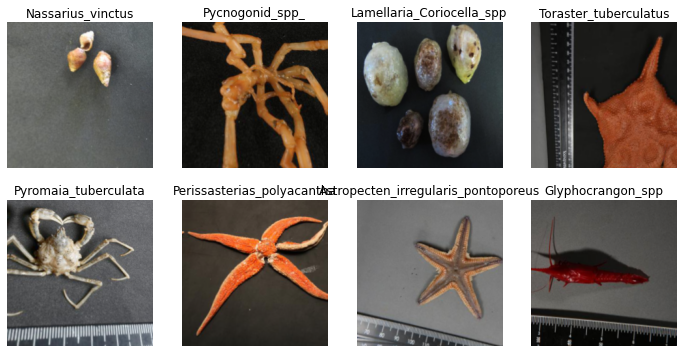

In [ ]:
#show some of the images with lables
dls.train.show_batch(max_n= 8, nrows = 2)

# ResNet34 Model Training

 CNN learner using resnet34:

In [ ]:
#CNN learner using resnet34:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
#use lr_find() to find a suitable learning rate
lr_min,lr_steep = learn.lr_find()

In [ ]:
#then we can train the model using fit_one_cycle
learn.fit_one_cycle(5, 3e-3)

In [ ]:
#Now we can unfreeze the network and train the whole networK
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-5,5e-4))

In [ ]:
#interpret the model.
interp = ClassificationInterpretation.from_learner(learn)

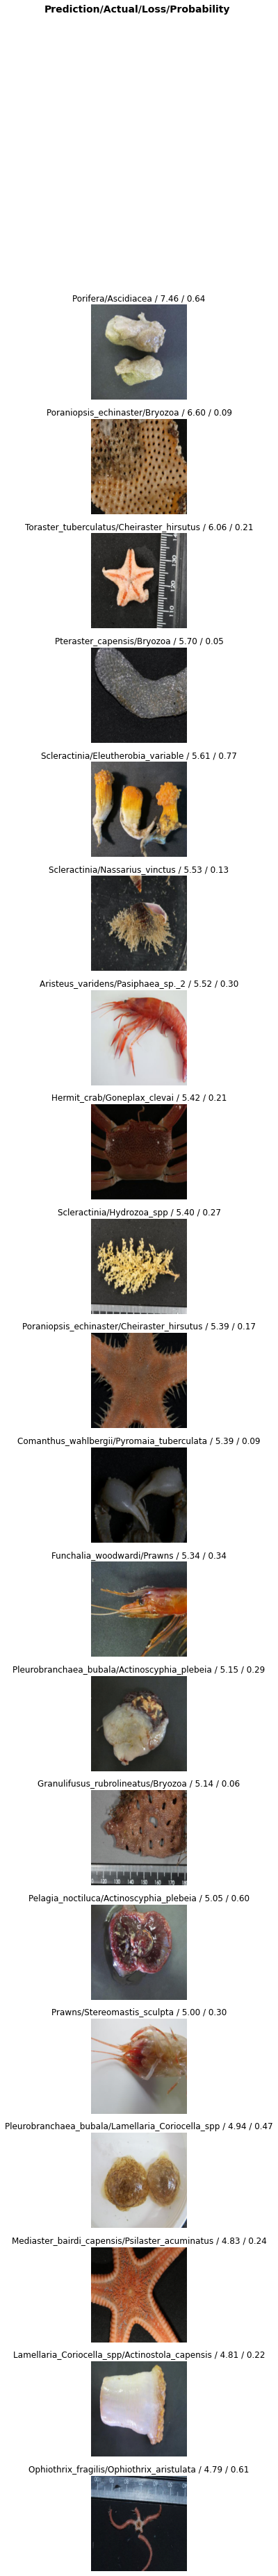

In [ ]:
#use this to see the image with the highest loss.
interp.plot_top_losses(20, nrows = 20)

In [ ]:
# ImageClassifierCleaner (a GUI) helps to clean the faulty images by 
#deleting them or renaming their labels. This greatly helps in data preprocessing 
#resulting in improved model accuracy.

from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
!pip install fastbook

In [ ]:
test_dl = dls.test_dl(get_image_files(
    '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'))

In [ ]:
 preds_test,y_test= learn.get_preds(dl=test_dl)

In [ ]:
sub=pd.read_csv('/content/SampleSubmission_.csv')
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [ ]:
len(preds_test)

1434

In [ ]:
import os
test_dir = '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'

submission = pd.DataFrame({'FILE': [s for s in os.listdir(test_dir)]})
for i, c in enumerate(dls.vocab):
  submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

FILE  Pteraster_capensis  ...  Triviella_spp_  Cheilostomatida
0  G8PHJSZ.jpeg            0.000057  ...        0.000326         0.001069
1  U2MI1BJ.jpeg            0.000011  ...        0.000075         0.000187
2  UBCBBMK.jpeg            0.000691  ...        0.000427         0.003627
3  ADY4PFX.jpeg            0.000248  ...        0.000077         0.008841
4  V7TZCMG.jpeg            0.003887  ...        0.001044         0.002621

[5 rows x 138 columns]

In [ ]:
submission.to_csv('fastai.csv', index = False)

# Fine Tuning ResNet34 

 CNN learner using resnet34:

In [ ]:
#CNN learner using resnet34:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

ValueError: ignored

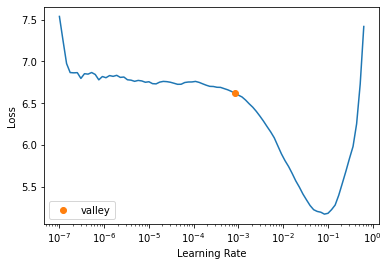

In [ ]:
#use lr_find() to find a suitable learning rate
lr_min,lr_steep = learn.lr_find()

In [ ]:
#then we can train the model using fit_one_cycle
learn.fit_one_cycle(5, 0.001)

In [ ]:
#Now we can unfreeze the network and train the whole networK
learn.unfreeze()
learn.fit_one_cycle(15, lr_max=slice(1e-4,5e-4))

In [ ]:
#interpret the model.
interp = ClassificationInterpretation.from_learner(learn)

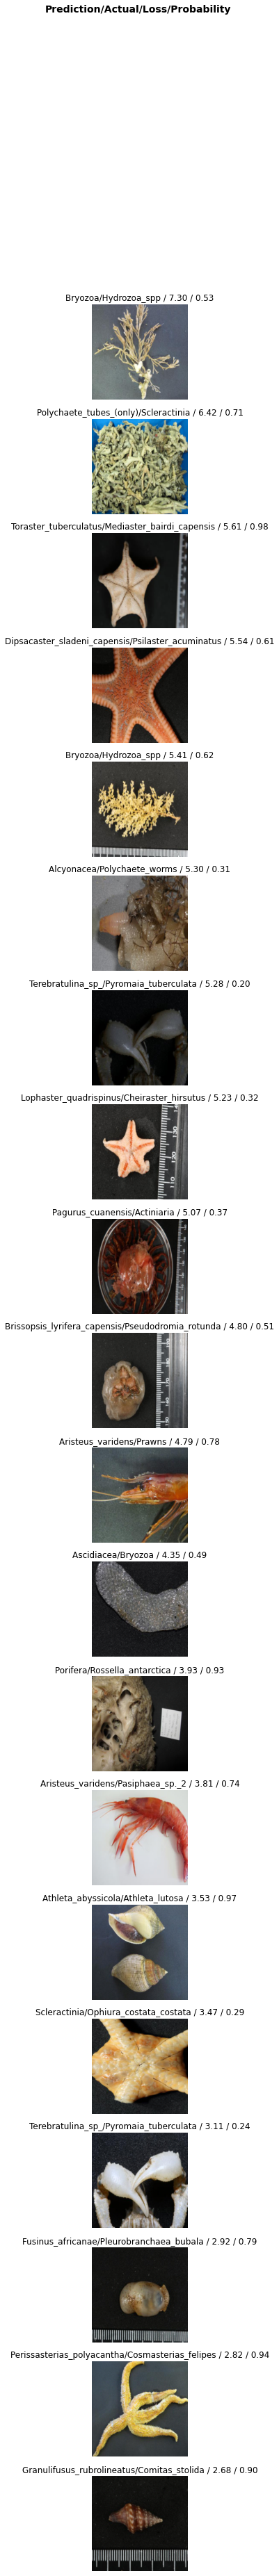

In [ ]:
#use this to see the image with the highest loss.
interp.plot_top_losses(20, nrows = 20)

In [ ]:
# ImageClassifierCleaner (a GUI) helps to clean the faulty images by 
#deleting them or renaming their labels. This greatly helps in data preprocessing 
#resulting in improved model accuracy.

from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
test_dl = dls.test_dl(get_image_files(
    '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'))

In [ ]:
 preds_test,y_test= learn.get_preds(dl=test_dl)

In [ ]:
sub=pd.read_csv('/content/SampleSubmission_.csv')
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [ ]:
len(preds_test)

1434

In [ ]:
import os
test_dir = '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'

submission = pd.DataFrame({'FILE': [s for s in os.listdir(test_dir)]})
for i, c in enumerate(dls.vocab):
  submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

FILE  Pteraster_capensis  ...  Triviella_spp_  Cheilostomatida
0  G8PHJSZ.jpeg        1.421621e-06  ...        0.000009     1.432195e-05
1  U2MI1BJ.jpeg        6.174075e-07  ...        0.000002     3.811797e-06
2  UBCBBMK.jpeg        2.268668e-07  ...        0.000001     2.307408e-08
3  ADY4PFX.jpeg        1.252047e-04  ...        0.000022     1.935887e-03
4  V7TZCMG.jpeg        2.861999e-04  ...        0.000264     1.921007e-03

[5 rows x 138 columns]

In [ ]:
submission.to_csv('resnet34_epoch15.csv', index = False)

# ResNet101 Model Training

 CNN learner using resnet34:

In [ ]:
#CNN learner using resnet34:
learn = cnn_learner(dls, xse_resnet101, metrics=error_rate)

NameError: ignored

In [ ]:
#use lr_find() to find a suitable learning rate
lr_min,lr_steep = learn.lr_find()

In [ ]:
#then we can train the model using fit_one_cycle
learn.fit_one_cycle(5, 3e-3)

In [ ]:
#Now we can unfreeze the network and train the whole networK
learn.unfreeze()
learn.fit_one_cycle(15, lr_max=slice(1e-5,5e-4))

RuntimeError: ignored

In [ ]:
#interpret the model.
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#use this to see the image with the highest loss.
interp.plot_top_losses(20, nrows = 20)

In [ ]:
test_dl = dls.test_dl(get_image_files(
    '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'))

In [ ]:
 preds_test,y_test= learn.get_preds(dl=test_dl)

In [ ]:
sub=pd.read_csv('/content/SampleSubmission_.csv')
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [ ]:
len(preds_test)

1434

In [ ]:
import os
test_dir = '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'

submission = pd.DataFrame({'FILE': [s for s in os.listdir(test_dir)]})
for i, c in enumerate(dls.vocab):
  submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

FILE  Pteraster_capensis  ...  Triviella_spp_  Cheilostomatida
0  G8PHJSZ.jpeg        4.632667e-08  ...    2.973243e-06     1.594491e-05
1  U2MI1BJ.jpeg        1.401954e-09  ...    2.155062e-07     1.037370e-10
2  UBCBBMK.jpeg        1.655332e-06  ...    9.394500e-08     6.494311e-08
3  ADY4PFX.jpeg        1.203131e-04  ...    1.910277e-05     8.598445e-04
4  V7TZCMG.jpeg        2.670238e-05  ...    5.669372e-04     2.583342e-05

[5 rows x 138 columns]

In [ ]:
submission.to_csv('resnet101_epoch15.csv', index = False)

# vgg19_bn Model Training

 CNN learner using resnet34:

In [ ]:
#CNN learner using resnet34:
learn = cnn_learner(dls, densenet121, metrics=error_rate)

AttributeError: ignored

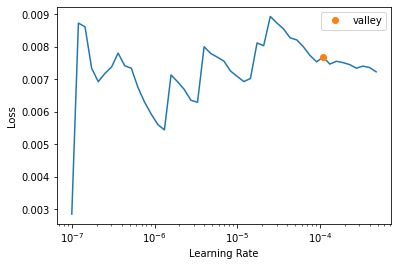

In [ ]:
#use lr_find() to find a suitable learning rate
#lr_min,lr_steep = learn.lr_find()

learn.lr_find()
learn.recorder.plot()

In [ ]:
#then we can train the model using fit_one_cycle
learn.fit_one_cycle(5, 3e-3)

In [ ]:
#Now we can unfreeze the network and train the whole networK lr_max=slice(1e-8,3e-4)
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(1e-5,5e-4))

RuntimeError: ignored

In [ ]:
#interpret the model.
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#use this to see the image with the highest loss.
interp.plot_top_losses(20, nrows = 20)

In [ ]:
test_dl = dls.test_dl(get_image_files(
    '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'))

In [ ]:
 preds_test,y_test= learn.get_preds(dl=test_dl)

In [ ]:
sub=pd.read_csv('/content/SampleSubmission_.csv')
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [ ]:
len(preds_test)

1434

In [ ]:
import os
test_dir = '/content/drive/MyDrive/Data Science/Marine Invertebrates Classification Challenge/Data/Marine Invertebrates Data/test_small/test_small'

submission = pd.DataFrame({'FILE': [s for s in os.listdir(test_dir)]})
for i, c in enumerate(dls.vocab):
  submission[c] = preds_test[:,i]
submission = submission[k] # Get same order as sample sub
submission.head()

FILE  Pteraster_capensis  ...  Triviella_spp_  Cheilostomatida
0  G8PHJSZ.jpeg        1.251405e-05  ...    1.307739e-06     7.228142e-05
1  U2MI1BJ.jpeg        1.666666e-09  ...    3.667500e-07     9.100118e-09
2  UBCBBMK.jpeg        8.589303e-10  ...    1.062301e-10     5.660211e-09
3  ADY4PFX.jpeg        4.708806e-07  ...    8.829156e-07     8.818343e-04
4  V7TZCMG.jpeg        1.404878e-04  ...    2.121596e-04     1.065622e-03

[5 rows x 138 columns]

In [ ]:
submission.to_csv('densnet121_constantLR.csv', index = False)